In [ ]:
# in this method we will train model to detect BBOx as we need
from google.colab import drive
drive.mount('/content/drive')
import os
directory_list = os.listdir('/content/drive/My Drive')
print(directory_list)
all_items = os.listdir('/content/drive/My Drive')
print(all_items)

print("Current directory:", os.getcwd())
new_directory = '/content/drive/My Drive'
os.chdir(new_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['USA Documents ', 'WildLife Animal Detection Project proposed ideas.gdoc', 'YOLOv8', 'Thesis', 'yolov8n.pt', 'Abstract.gdoc']
['USA Documents ', 'WildLife Animal Detection Project proposed ideas.gdoc', 'YOLOv8', 'Thesis', 'yolov8n.pt', 'Abstract.gdoc']
Current directory: /content/drive/My Drive


Mounted at /content/drive


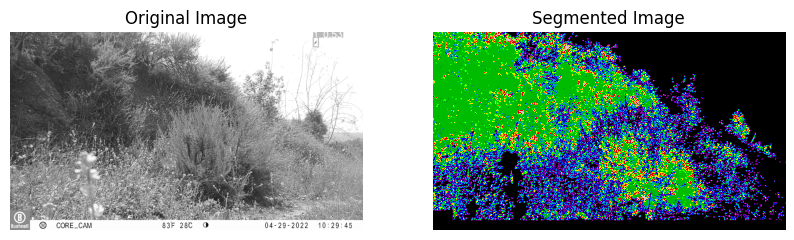

In [ ]:
import numpy as np
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
import scipy.stats as scista
!pip install pygco
import pygco

drive.mount('/content/drive', force_remount=True)

class MarkovRandomField:
    def __init__(self, img, seeds, alpha=1, beta=1):
        self.img = img
        self.seeds = seeds
        self.alpha = alpha
        self.beta = beta
        self.n_labels = np.max(seeds) + 1  # Assuming seed labels start from 0
        self.pairwise = -self.alpha * np.eye(self.n_labels, dtype=np.int32)  # n_labels x n_labels
        self.unaries = None
        self.labels = None

    def estimate_models(self):
        # Placeholder to set models based on image data or seeds
        models = []
        for i in range(self.n_labels):
            mask = self.seeds == i
            if np.any(mask):
                mu, sigma = scista.norm.fit(self.img[mask])
                models.append((mu, sigma))
            else:
                models.append((0, 1))  # Dummy values for unused label
        return models

    def calculate_unaries(self, models):
        unaries_list = []
        for mu, sigma in models:
            dist = scista.norm(mu, sigma)
            unary = -np.log(dist.pdf(self.img.flatten()) + 1e-10)
            unaries_list.append(unary.reshape(-1, 1))
        self.unaries = self.beta * np.hstack(unaries_list).astype(np.int32)

    def run(self):
        models = self.estimate_models()
        self.calculate_unaries(models)

        # Define edges
        inds = np.arange(self.img.size).reshape(self.img.shape)
        horz = np.c_[inds[:, :-1].ravel(), inds[:, 1:].ravel()]
        vert = np.c_[inds[:-1, :].ravel(), inds[1:, :].ravel()]
        edges = np.vstack([horz, vert]).astype(np.int32)

        # Perform graph cut
        self.labels = pygco.cut_from_graph(edges, self.unaries, self.pairwise, n_iter=-1, algorithm='expansion')
        return self.labels.reshape(self.img.shape)

# Load the image
image_path = '/content/drive/My Drive/YOLOv8/runs/detect/predict3/04290500.JPG'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    print("Image not loaded. Check the path.")

# Example seeds (manually define or load from data)
seeds = np.zeros_like(image)
seeds[50:100, 50:100] = 1
seeds[150:200, 150:200] = 2

# Initialize the MRF model
mrf = MarkovRandomField(image, seeds, alpha=1, beta=1)
labels = mrf.run()

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Segmented Image')
plt.axis('off')
plt.show()
